# 1. Data cleaning

## Problem statement

This project is meant as an exercise in basic classification as a training after reading the first three chapters of Hands-On Machine Learning with Scikit-Learn, Keras and Tensorflow by Géron.

### Learning goal: practise implementing a simple end-to-end classification task
Rather than try and achieve very performant results (e.g. optimising an accuracy metric) a focus is to cover all major steps of a typical classification task:
1. Data collection
2. Data cleaning and preprocessing
3. Exploratory data analysis
4. Training of Machine Learning algorithms
5. Optimising the chosen ML technique
6. Drawing insights and conclusions
7. Deployment

The sequential steps are described in separate notebooks.

### Business goal: detect customers that are likely to cancel their credit-card subscription
I found the dataset on Kaggle:
https://www.kaggle.com/sakshigoyal7/credit-card-customers

It comes from a real-life scenario: a bank manager is unhappy that quite a few customers have been cancelling their credit card membership. He/She wants to find out if it's possible to detect such discontent customers early on and win them over by proposing attractive offers before it's too late.
The data has been collected by a Kaggle user, however, it requires some preparation due to:
- text rather than numeric values
- missing values

## Load utilities and programming set up

Let's start by loading the useful libraries, specifying the input data file, and preparing a utility function that will be used to save any figures later on.

In [42]:
# Usual imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
assert sklearn.__version__ >= "0.20"

# Pretty plotting
%matplotlib inline
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Data file name (easy to change for a similar project)
DATA_FILE = "BankChurners.csv"

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)  # It's fine if the directory already exists (No action needed)

def save_fig(fig_name, tight_layout=True, fig_extension="png", resolution=300):
    "Save figure ensurring correct directory, extension, resolution and layout"
    path = os.path.join(IMAGES_PATH, fig_name + "." + fig_extension)
    print("Saving figure", fig_name)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Load the data

Below I define and call a utility function that loads the data into a pandas DataFrame.
Then, we can have a glimpse at the data.

In [43]:
def load_data(data_path = PROJECT_ROOT_DIR, data_file = DATA_FILE):
    "Load csv data into a pandas DataFrame"
    csv_path = os.path.join(data_path, data_file)
    return pd.read_csv(csv_path)
df = load_data()
df.head(100)

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,719712633,Existing Customer,64,M,1,Graduate,Married,Less than $40K,Blue,52,...,1709.0,895,814.0,1.656,1673,32,0.882,0.524,0.000343,0.999660
96,772629333,Existing Customer,45,M,3,Graduate,Married,$40K - $60K,Blue,35,...,3454.0,1200,2254.0,0.597,1313,30,0.304,0.347,0.000226,0.999770
97,720336708,Existing Customer,53,M,3,Doctorate,Married,$40K - $60K,Blue,35,...,3789.0,1706,2083.0,1.047,1609,42,0.680,0.450,0.000270,0.999730
98,802013583,Existing Customer,56,M,3,College,Married,$120K +,Blue,50,...,9689.0,2250,7439.0,0.576,1158,19,0.727,0.232,0.000042,0.999960


In [44]:
# Show percentage of attrited and existing customers
df.groupby("Attrition_Flag").count() / df.shape[0] * 100

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
Attrition_Flag,,,,,,,,,,,,,,,,,,,,,
Attrited Customer,16.065962,16.065962,16.065962,16.065962,16.065962,16.065962,16.065962,16.065962,16.065962,16.065962,...,16.065962,16.065962,16.065962,16.065962,16.065962,16.065962,16.065962,16.065962,16.065962,16.065962
Existing Customer,83.934038,83.934038,83.934038,83.934038,83.934038,83.934038,83.934038,83.934038,83.934038,83.934038,...,83.934038,83.934038,83.934038,83.934038,83.934038,83.934038,83.934038,83.934038,83.934038,83.934038


We notice that:
- The first column is a unique client number; we won't use it
- The second one is the client category: either "Existing Customer" or "Attrited Customer". We'll use it as a label for the classification algorithms. Note the imbalance between the existing (84%) and attrited (16%) customers. Hence the problem we're dealing with is actually **imbalanced classification** (more on it below)
- The next columns are various characteristics of each customer, potentially feautures of an ML algorithm
- Some columns are text-based. They need to be translated into numeric values to be ready for an ML technique.

### Imbalanced classification
Having the class ratio significantly different from 1:1 (as it is the case here) may cause an ML algorithm to ignore the minority class. This is obviously undesirable.
While there's no magic solution to the problem, there exist a number of strategies to try out:
1. Use a more suitable performance metric than accuracy, e.g. confusion matrix
2. Over(under) sample the minority (majority) class.
3. Syntehise the feautures of the minory class to manufacture plausible new instances of the minority class (the SMOTE technique)
3. Choose an algorithm that can mitigate the imbalanced class representation
4. Gather more data (not feasible if the imbalance is intrinsic to the process as it is the case in churn/anomaly/fraud detection, etc.)

More information:
- https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
- SMOTE: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

For the step-by-step development I'd proceed as follows:
1. Ignore the "elephant in the room" to firstly focus on the overall workflow
2. Use the confusion matrix (or similar) as a peformance measure
3. Pick an easy solution to tackle the imbalanced classification (e.g. over-sample the minority class)

Moreover, the dataset author tells that he's been working on Naive Bayes classifier with no satisfactory outcome.
Therefore the corresponding columns are rather *outputs* than *inputs* (features) and let's drop them together with the client number.

In [45]:
for col in [
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2",
    "CLIENTNUM",
    ]:
    print(col)
    df = df.drop(col, axis=1)

Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1
Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
CLIENTNUM


Let's display more information about the dataset with `df.info()`.

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

Peeking at the dataset reveals that there are:
- 20 columns: the label "Attrition_Flag" and 19 features
- 5 columns have non-numerical (i.e. text-based) data (`object` type)
- There are `Unknown` values, which obviously are actual null values and should be dealt with

Now, let's have a look at correlations between feautures.
At this stage some values are non-numerical and, consequently, ignored in correlation computations.
TODO: It would be interesting to digitise the text. Especially correlations with the target labels might prove useful.

In [47]:
corr_matrix = df.corr()
corr_matrix
# unfortunately, no correlations with the label that is still text-based (not numerical)

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
Customer_Age,1.000000,-0.122254,0.788912,-0.010931,0.054361,-0.018452,0.002476,0.014780,0.001151,-0.062042,-0.046446,-0.067097,-0.012143,0.007114
Dependent_count,-0.122254,1.000000,-0.103062,-0.039076,-0.010768,-0.040505,0.068065,-0.002688,0.068291,-0.035439,0.025046,0.049912,0.011087,-0.037135
Months_on_book,0.788912,-0.103062,1.000000,-0.009203,0.074164,-0.010774,0.007507,0.008623,0.006732,-0.048959,-0.038591,-0.049819,-0.014072,-0.007541
Total_Relationship_Count,-0.010931,-0.039076,-0.009203,1.000000,-0.003675,0.055203,-0.071386,0.013726,-0.072601,0.050119,-0.347229,-0.241891,0.040831,0.067663
Months_Inactive_12_mon,0.054361,-0.010768,0.074164,-0.003675,1.000000,0.029493,-0.020394,-0.042210,-0.016605,-0.032247,-0.036982,-0.042787,-0.038989,-0.007503
Contacts_Count_12_mon,-0.018452,-0.040505,-0.010774,0.055203,0.029493,1.000000,0.020817,-0.053913,0.025646,-0.024445,-0.112774,-0.152213,-0.094997,-0.055471
Credit_Limit,0.002476,0.068065,0.007507,-0.071386,-0.020394,0.020817,1.000000,0.042493,0.995981,0.012813,0.171730,0.075927,-0.002020,-0.482965
Total_Revolving_Bal,0.014780,-0.002688,0.008623,0.013726,-0.042210,-0.053913,0.042493,1.000000,-0.047167,0.058174,0.064370,0.056060,0.089861,0.624022
Avg_Open_To_Buy,0.001151,0.068291,0.006732,-0.072601,-0.016605,0.025646,0.995981,-0.047167,1.000000,0.007595,0.165923,0.070885,-0.010076,-0.538808
Total_Amt_Chng_Q4_Q1,-0.062042,-0.035439,-0.048959,0.050119,-0.032247,-0.024445,0.012813,0.058174,0.007595,1.000000,0.039678,0.005469,0.384189,0.035235


'Credit_Limit' is 99.6% correlated with 'Avg_Open_To_Buy'. Therefore the latter feature can be dropped.

In [48]:
df = df.drop("Avg_Open_To_Buy", axis=1)

## Create train and test sets
Despite we're only at the cleaning stage, arguably it's a good practice to already seperate out the test set from the training one to avoid (analyst's) biases.

Let's use 20% of the dataset as the test sample.
To ensure representative sampling we're using the stratified shuffle split: the feautures distributions should agree between the train and test samples.
However, stratified sampling does not address the above-mentioned _imbalance_ between the class labels.
TODO: Let's keep that in mind and tackle at a later stage.

In [49]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['Attrition_Flag']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    
print(strat_train_set['Attrition_Flag'].value_counts() / len(strat_train_set))
print(strat_test_set['Attrition_Flag'].value_counts() / len(strat_test_set))

Existing Customer    0.839279
Attrited Customer    0.160721
Name: Attrition_Flag, dtype: float64
Existing Customer    0.839585
Attrited Customer    0.160415
Name: Attrition_Flag, dtype: float64


### Saving the dataset for the next step
For the sake of clarity, let's save the current data set using the `pickle` module.
In the next notebook we'll further explore the data.

In [50]:
strat_train_set.to_pickle("dataset_train_step1.pickle")
strat_test_set.to_pickle("dataset_test_step1.pickle")

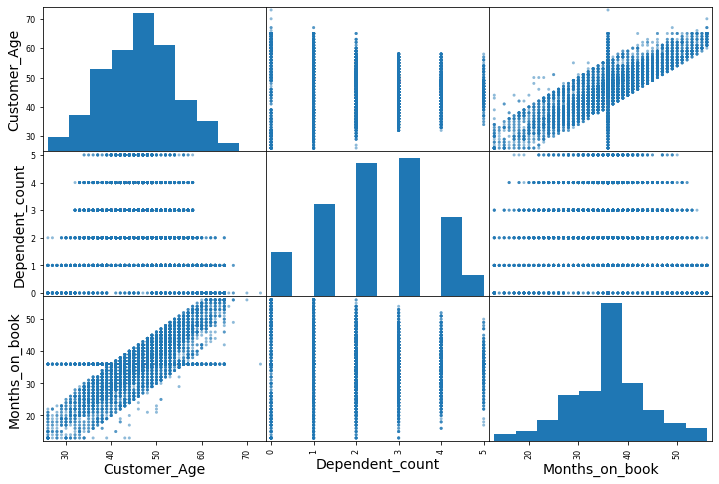

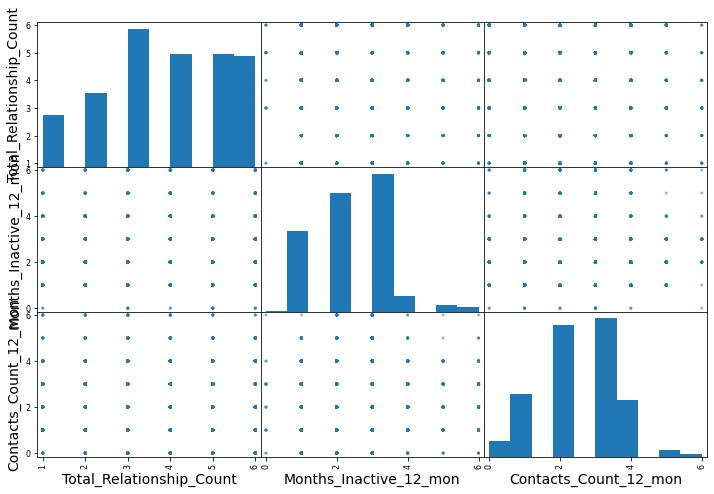

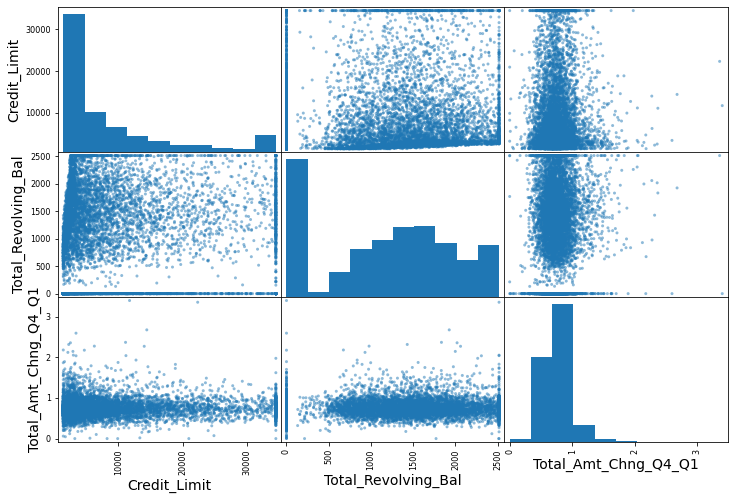

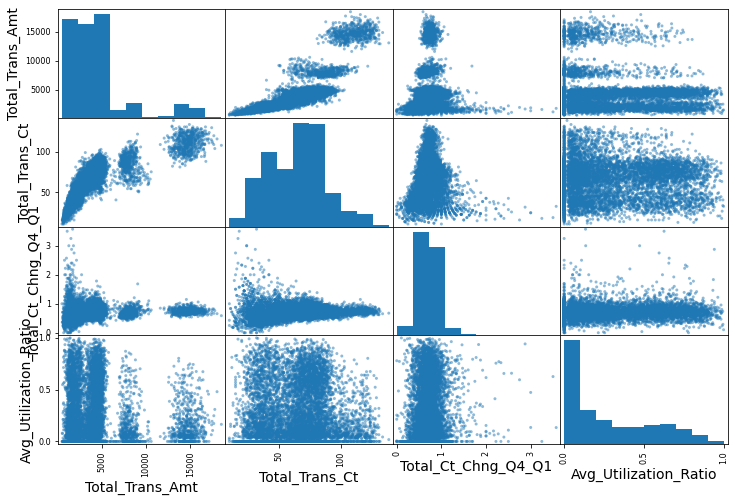

In [30]:
corr_matrix = df.corr()
from pandas.plotting import scatter_matrix
# Use a loop for more readable results
def get_cols_subset(i, n):
    cols = corr_matrix.columns
    chunk_size = len(cols) / n
    return cols[int(i*chunk_size):int((i+1)*chunk_size)]

N = 4
for i in range(N):
    cols = get_cols_subset(i,N)
    scatter_matrix(df[cols], figsize=(12,8))

In [12]:
# Superstitious copying once again
df = strat_train_set.drop("Attrition_Flag", axis=1)
credit_labels = strat_train_set['Attrition_Flag'].copy()

# Translate text to numbers and fill out unknowns

In [13]:
text_cols = df.dtypes[df.dtypes == np.object]
text_cols_names = list(text_cols.index)
num_cols = df.dtypes[df.dtypes != np.object]
num_cols_names = list(num_cols.index)
text_cols_names
num_cols_names

['CLIENTNUM',
 'Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [14]:
# Check what are the possible values of the text-based cells
for name in text_cols_names:
    print("Column", name)
    print(df[name].value_counts())
    print()

Column Gender
F    4262
M    3839
Name: Gender, dtype: int64

Column Education_Level
Graduate         2442
High School      1603
Unknown          1232
Uneducated       1219
College           829
Post-Graduate     404
Doctorate         372
Name: Education_Level, dtype: int64

Column Marital_Status
Married     3755
Single      3156
Unknown      599
Divorced     591
Name: Marital_Status, dtype: int64

Column Income_Category
Less than $40K    2838
$40K - $60K       1442
$80K - $120K      1244
$60K - $80K       1104
Unknown            873
$120K +            600
Name: Income_Category, dtype: int64

Column Card_Category
Blue        7541
Silver       455
Gold          91
Platinum      14
Name: Card_Category, dtype: int64



Ordinal encoders:
- all above but marital status
- Education level needs sorting

How to deal with unknowns?
- Mean: education, income
- marital status: 'unknown' must not be a separate category (onehot enc.) not to fool ML
    1. Skip this column
    2. Inspect if unknowns are Attrited Customers who are 16%, so their statistics is essential...

In [15]:
def sort_edu(val):
    order = ["Uneducated", "High School", "College", "Graduate", "Post-Graduate", "Doctorate"]
    if val in order:
        return order.index(val)
    # For unknowns return NaN to later on apply median
    return np.nan

df['Education'] = df.apply(lambda x: sort_edu(x["Education_Level"]), axis=1)
num_cols_names.append('Education')    

In [16]:
def avg_income(val):
    if val == 'Unknown':
        return np.nan
    import re
    matches = re.findall("\$[0-9]*K", val)
    matches = [float(x.replace('$','').replace('K','')) for x in matches]
    if len(matches) == 1:
        return matches[0]
    return sum(matches) / len(matches)
#avg_income("$60K - $80K")
df['Avg_Income'] = df.apply(lambda x: avg_income(x['Income_Category']), axis=1)
df['Avg_Income']
# Add this column to the numerical ones and remove from the categorical ones
num_cols_names.append('Avg_Income')

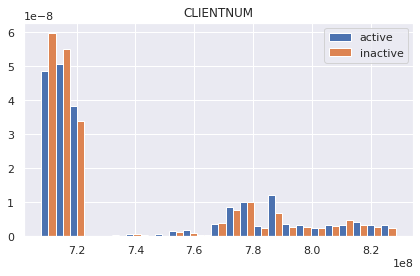

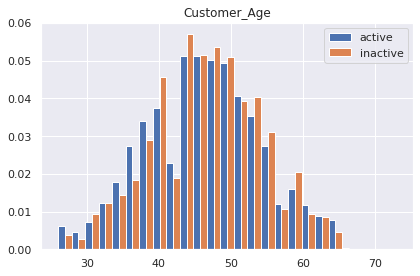

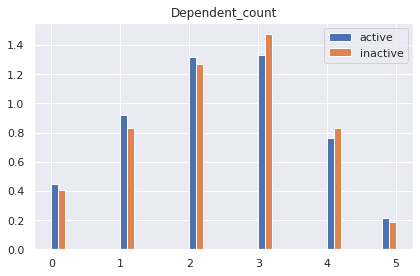

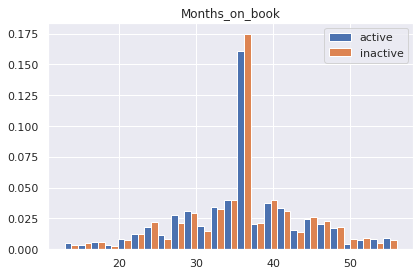

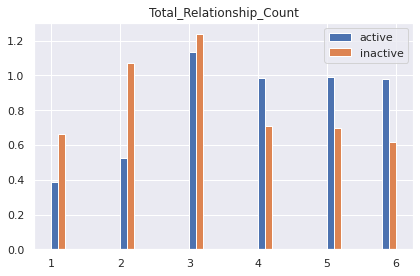

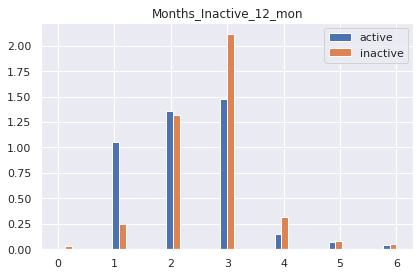

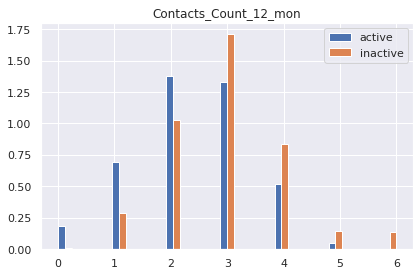

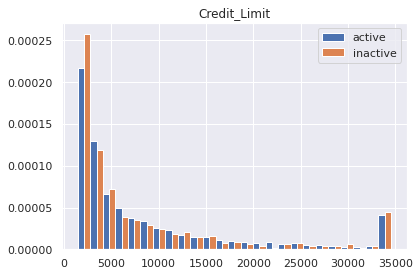

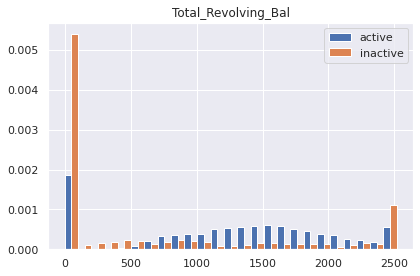

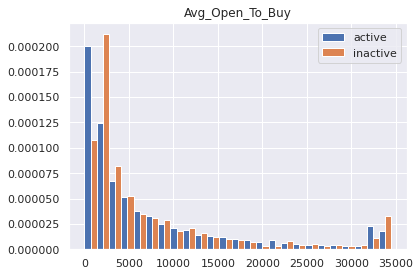

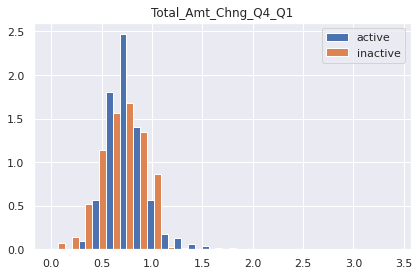

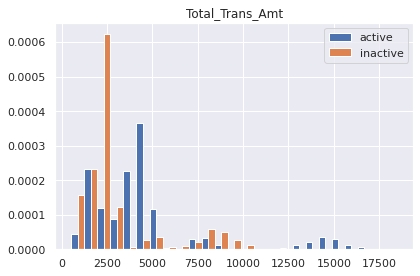

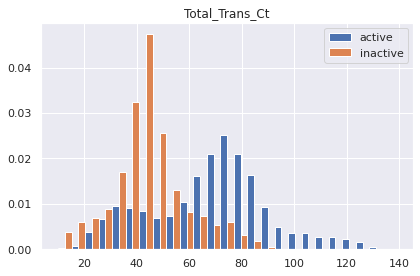

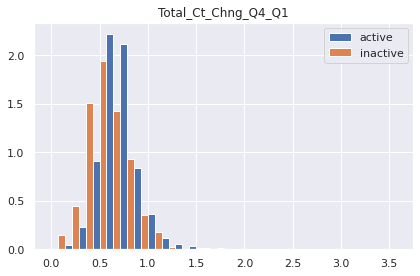

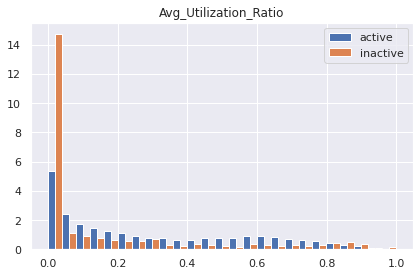

In [19]:
import seaborn as sns

# Split dataframe into two groups of customers (for plotting only)
df_active = strat_train_set.loc[strat_train_set['Attrition_Flag']=="Existing Customer"]
df_inactive = strat_train_set.loc[strat_train_set['Attrition_Flag']=="Attrited Customer"]
# Apply the default theme
sns.set_theme(font_scale=1)
colours = ('blue', 'red')
for col in df.columns:
    if df[col].dtypes == np.object:
        continue
    if col=='Education' or col=='Avg_Income':
        continue # hack because df has no access to label :-()
    #f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    #axes = (ax1, ax2)
    #for i, df_i in enumerate((df_active, df_inactive)):
    fig = plt.figure() 
    ax = fig.add_subplot(111)
    ax.hist([df_active[col], df_inactive[col]], label=("active", "inactive"), bins=25, density=True,rwidth=1.0)#, range=[0, 25])
    ax.set_title(col)
    ax.legend()
        #df_i.hist(column=col, bins=30, figsize=(8,3), color=colours[i], ax=axes[i])#, layout=(10,2))
        #save_fig("attribute_histogram_plots")
    plt.tight_layout()
    plt.show()

Features that distinguish the two categories of customers:
['Total_Relationship_Count', 'Months_inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal',
'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
'Avg_Utilization_Ratio']

Not so sure, but taken:
['Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1']

Credit limit has a peak at the upper-most bin. This may suggest putting all above-the-limit entries into that bin (i.e. rounding down all above 35000 to 35000).EDIT: actually this may be a max credit limit offerred by the bank...

In [20]:
from sklearn.preprocessing import OrdinalEncoder
# ordinal_encoder = OrdinalEncoder()
# attrition_flag_encoded = ordinal_encoder.fit_transform(df[["Card_Category"]])
# attrition_flag_encoded[:10]
# #ordinal_encoder.categories_

ordered_cols_names = "Gender Card_Category".split()
#onehot_cols_names = "Marital_Status".split()

# from sklearn.preprocessing import OneHotEncoder
# cat_encoder = OneHotEncoder()
# marital_1hot = cat_encoder.fit_transform(df[['Marital_Status']])
# marital_1hot.toarray()

The only NaNs to be fixed are the ones in num_cols_names, specifically in education and income.
Let's assign median to these.

In [21]:
from sklearn.impute import SimpleImputer

In [22]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# All the numeric data preprocessing:
# - usually NaNs (e.g. median)
# - adding extra attributes (e.g. functions of the original ones)
# - scaling: standardisation or normalisation
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

from sklearn.compose import ColumnTransformer

powerful_features = ['Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal',
'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
'Avg_Utilization_Ratio']
for name in num_cols_names:
    if name not in powerful_features:
        print('Not good:', name)
        num_cols_names.remove(name)

# Final list of features to be used (not sure about the ordered ones; not checked their discriminating power)
print("Final list of features to be used:", num_cols_names + ordered_cols_names)

# ColumnTransformer executes the pipelines on specified lists of column names
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_cols_names),
    ('ordered', OrdinalEncoder(), ordered_cols_names)
    #('cat', OneHotEncoder(), text_cols_names),
])

credit_prepared = full_pipeline.fit_transform(df)
from sklearn.preprocessing import LabelEncoder
credit_labels_prepared = LabelEncoder().fit_transform(credit_labels)
print(credit_labels_prepared)
# So far all categorical columns were treated with OneHotEncoder, which is not ideal and later I can specify new
# categories for those cat. columns that should be treated otherwise. Nice setup!

Not good: CLIENTNUM
Not good: Dependent_count
Not good: Credit_Limit
Not good: Education
Final list of features to be used: ['Customer_Age', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Avg_Income', 'Gender', 'Card_Category']
[0 1 1 ... 1 1 1]


In [23]:
credit_prepared

array([[ 0.96087863,  1.64154853,  1.40868897, ..., -0.45995856,
         0.        ,  0.        ],
       [ 0.58518711,  1.13884339, -0.5306623 , ...,  1.44306713,
         1.        ,  0.        ],
       [-0.16619592, -0.87197715, -0.5306623 , ..., -0.45995856,
         0.        ,  0.        ],
       ...,
       [ 0.45995661,  0.00775684,  1.40868897, ..., -0.8405637 ,
         0.        ,  0.        ],
       [-0.41665693,  0.00775684, -0.5306623 , ...,  0.30125171,
         1.        ,  0.        ],
       [ 0.96087863,  0.00775684,  0.76223855, ...,  0.30125171,
         1.        ,  0.        ]])

In [24]:
type(credit_prepared)

numpy.ndarray

# Choose and train a ML model

In [26]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(credit_prepared, credit_labels_prepared)

LinearRegression()

In [28]:
# Let's try it out
some_data = df.iloc[:5]
some_labels = credit_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [0.42865919 1.23814271 0.89783302 0.87524327 0.8181202 ]
Labels: ['Attrited Customer', 'Existing Customer', 'Existing Customer', 'Existing Customer', 'Existing Customer']


In [29]:
from sklearn.metrics import mean_squared_error
credit_predictions = lin_reg.predict(credit_prepared)
lin_mse = mean_squared_error(credit_labels_prepared, credit_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.29075752512231773

In [31]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(credit_prepared, credit_labels_prepared)

credit_predictons = tree_reg.predict(credit_prepared)
tree_mse = mean_squared_error(credit_labels_prepared, credit_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.29075752512231773

In [33]:
# the above looks fishy -> same number?
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, credit_prepared, credit_labels_prepared, scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [0.25563923 0.21659543 0.21942686 0.27216553 0.248452   0.22771002
 0.24088315 0.25337232 0.25819889 0.22771002]
Mean: 0.24201534405531114
Standard deviation: 0.017589600745373773


In [34]:
lin_scores = cross_val_score(lin_reg, credit_prepared, credit_labels_prepared,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.2904641  0.29092639 0.27747691 0.30298606 0.30020822 0.2985719
 0.29140202 0.2784484  0.29261424 0.29044852]
Mean: 0.2913546759788459
Standard deviation: 0.007926622475223289


The first column shows a unique identifier for each client;  it will prove useful in randomly splitting into train- and test-set. Although explicitly there are no null values, some of them are marked as e.g. 'unknown' and should be considered as null values.
The data provider suggested to remove the last two columns (they might be some work-in-progress development...).


# Create a Test Test

For simplicity and because the dataset is reasonably large (10k customers), a random split should suffice and bring a roughly homogenous test sample.

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

Project TODOs:

    + plot features for 'signal' and 'background'
    - decide when to split into train/test set and how (k-fold)
    - consider 'balanced' training 'signal' and 'background'
    - train a bunch of models
    - shortlist the best ones
    - fine tune them
    - deploy the result